# Copernicus use cases exemples

## Imports

In [1]:
from sigmap.data import copernicus

from sigmap.polygeohasher import download_gadm_country, build_single_multipolygon, geohashes_to_boxes, geohashes_to_multipolygon

/opt/anaconda3/envs/Climate_Change_Visualizer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[20:50:39] DEBUG:matplotlib: matplotlib data path: /opt/anaconda3/envs/Climate_Change_Visualizer/lib/python3.12/site-packages/matplotlib/mpl-data
[20:50:39] DEBUG:matplotlib: CONFIGDIR=/Users/williamhubaux/.matplotlib
[20:50:39] DEBUG:matplotlib: interactive is False
[20:50:39] DEBUG:matplotlib: platform is darwin
[20:50:39] DEBUG:matplotlib: CACHEDIR=/Users/williamhubaux/.matplotlib
[20:50:39] DEBUG:matplotlib.font_manager: Using fontManager instance from /Users/williamhubaux/.matplotlib/fontlist-v390.json


In [2]:
# External import
import logging
import xarray as xr

import warnings
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from shapely import Polygon, MultiPolygon
from shapely.geometry import box

from typing import Union, List, Optional, Tuple

The package ```copernicusmarine``` uses urllib3 internally, with a logger at default in **DEBUG** who can create long output, this code snippet can be put on top of your script or in a notebook cell, like here, to change the log level to something more relevant.

In [3]:
# logging.getLogger("urllib3").setLevel(logging.WARNING)

Alternatively if you want to disable logger from a list of sources, you can do it like so:

In [4]:
for noisy_logger in ["urllib3", "copernicusmarine", "botocore", "s3transfer", "matplotlib"]:
    logging.getLogger(noisy_logger).setLevel(logging.CRITICAL) # CRITICAL is the top level so no other logging type will be display.


# Constants

In [5]:
DS_FOLDER = "../../datasets/"
CUSTOM_BBOX = box(-16.62, 29.54, 45.04, 60.09) # Large part of Europe

# Helpers

In [6]:
warnings.filterwarnings("ignore", category=RuntimeWarning, module="shapely")
def quick_data_plot(data):
    plot = data.plot(
        transform=ccrs.PlateCarree(),
        col='time',
        subplot_kws={'projection': ccrs.PlateCarree(), 'facecolor': 'gray'},
        cmap='Blues',
    )

    for ax in plot.axs.flat:
        ax.coastlines()
        ax.gridlines(draw_labels=True)

    plot.fig.subplots_adjust(wspace=0.5, hspace=0.5, right=0.75)

## List products

### Using keywords
The keywords are what the website use to filter the product in the Catalogue list. Those are often related to the ```Variables``` the ```Name``` and even the ```Data assimilation```

**NOTE**

I do not recommend this approach, I implement this behavior because my function wrap the ```copernicusmarine.describe()``` function who have this behavior, but it's only a programming way to get through the Copernicus catalogue. The function I build only return the list of ```CopernicusProducts``` related to the resulting ```CopernicusCatalogue``` from the ```copernicusmarine``` function call.

In [7]:
keyword_list = ['temperature']
try:
    products = copernicus.list_copernicus_products(keywords=keyword_list,
                                                   disable_progress_bar=True) # Optional boolean to display a progressbar, I recommend to keep the default value (TRUE), especially in notebooks
    print(f"Found {len(products)} products")
except Exception as e:
    print(f"Could not list products: {e}")


Found 139 products


Quick look at all the keywords that a product have, for demonstration purposes.

In [8]:
print(copernicus.get_meta(products[1])['keywords'])

['numerical-model', 'sea-ice-area-fraction', 'sea-ice-thickness', 'surface-snow-thickness', 'sea-ice-x-velocity', 'sea-ice-y-velocity', 'sea-ice-classification', 'sea-ice-albedo', 'sea-ice-volume-fraction-of-ridged-ice', 'sea-ice-age', 'multi-year', 'weather-climate-and-seasonal-forecasting', 'marine-safety', 'marine-resources', 'coastal-marine-environment', 'arctic-ocean', 'level-4', 'sea-ice-concentration-and/or-thickness', 'sst', 'sea-level', 'in-situ-ts-profiles']


### Using the product ID

A product determine what is the 'topic' the data are treating, so it's composed by multiple datasets. Those are sorted by the region, the casting, the model, the date range and the precision.

In [9]:
try:
    products = copernicus.list_copernicus_products(product_id='GLOBAL_ANALYSISFORECAST_PHY_001_024')
    print(f"Found {len(products)} products")
except Exception as e:
    print(f"Could not list products: {e}")

print(f"Found {len(copernicus.get_meta(products[0])['datasets'])} dataset(s)")

Found 1 products
Found 20 dataset(s)


### Using the dataset ID

This should only return you one product from the catalogue since the ```dataset ID``` should be unique.

In [10]:
try:
    products = copernicus.list_copernicus_products(dataset_id='cmems_mod_glo_phy_my_0.083deg_P1D-m')
    print(f"Found {len(products)} products")
except Exception as e:
    print(f"Could not list products: {e}")

Found 1 products


If needed you can collect all the metadata of the Product using the function ```get_meta()```

In [11]:
# Output is long so uncomment to see the result
# copernicus.get_meta(product)

## Fetch datasets

The main feature is to be able to download Copernicus dataset and specify all parameter needed.

### Base parameters

There is three mandatory variables that define what dataset with which variables and where to store the file. (if the '.nc' is not specified it will be automatically added.)

There is a bunch of optional parameter, the main ones are :
- The ```geometry```, the bbox of that geometry will define the AOI (Area Of Interest). By default the value is ```None``` and will take the entire dataset coverage.
- The ```time_range``` define the first and last date (in datetime format), the dataset defines the frequency.
- The ```force_download``` is a boolean that override the file if set to ```True```. By default this parameter is set to ```False``` so if the file is detected it won't be download (even if the data are different, it only check the file name)

In [12]:
dataset_id='cmems_mod_glo_phy_anfc_0.083deg_PT1H-m'
variables=['thetao'],
output_path= DS_FOLDER + "filename.nc"

# Optional
geometry: Union[Polygon, MultiPolygon, str, List[str], None] =None # None = Global coverage
time_range: Optional[Tuple[str, str]]=('2025-01-01', '2025-01-02')
force_download: bool = False # If True, download even if file exists

## Bathymetric dataset

Some dataset also have STATIC data such as the bathymetry.
The function call take the same parameters as the ```copernicus.subset()```function, so check from the Copernicus website for specific parameters.

In [13]:
output_path= DS_FOLDER + "bathy.nc"

copernicus.fetch_copernicus_data(
    dataset_id="cmems_mod_glo_phy_anfc_0.083deg_static",
    dataset_part="bathy",
    variables=["deptho", "deptho_lev"],
    output_path=output_path,
    depth_range=(0.49402499198913574, 5727.9169921875)
)
ds_bathy = xr.open_dataset(output_path)
ds_bathy

[20:50:59] INFO:sigmap.data.copernicus: File already exists (skipping download): ../../datasets/bathy.nc
[20:50:59] DEBUG:findlibs: about to search for libeccodes.dylib/eccodeslib in <function _find_in_package at 0x33a0f4f40>
[20:50:59] DEBUG:findlibs: found package eccodeslib; with preload_deps=False
[20:50:59] DEBUG:findlibs: found libeccodes.dylib/eccodeslib in <function _find_in_package at 0x33a0f4f40>
[20:50:59] DEBUG:gribapi.bindings: eccodes lib search: findlibs returned /opt/anaconda3/envs/Climate_Change_Visualizer/lib/python3.12/site-packages/eccodeslib/lib/libeccodes.dylib


<xarray.Dataset> Size: 141MB
Dimensions:     (latitude: 2041, longitude: 4320)
Coordinates:
  * latitude    (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude   (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
Data variables:
    deptho      (latitude, longitude) float64 71MB ...
    deptho_lev  (latitude, longitude) float64 71MB ...
Attributes:
    references:                http://marine.copernicus.eu
    copernicusmarine_version:  2.2.3

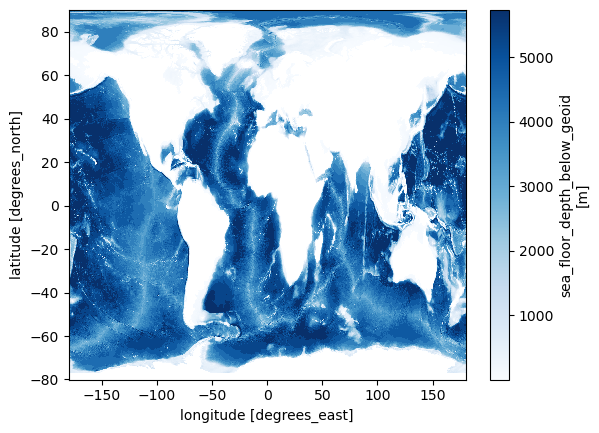

In [14]:
ds_bathy['deptho'][:,:].plot(cmap=plt.cm.Blues);

### Using a custom geometry

It's possible to create and use geometry from ```shapely``` to download dataset, by default it will use the BBOX of the object.

**NOTE :**
You can use the geometry as a mask by passing a boolean, the process is shown in [this section](#using-geometries-as-a-mask-for-the-dataset)

In [15]:
output_path= DS_FOLDER + "CUSTOM_sst_exemple_PT1H-m.nc"
geometry: Union[Polygon, MultiPolygon, str, List[str], None] =CUSTOM_BBOX

In [16]:
copernicus.fetch_copernicus_data(
        dataset_id=dataset_id,
        variables=['thetao'],
        output_path=output_path,
        geometry=geometry,
        time_range=time_range,
        force_download=True,
)

[20:51:02] INFO:sigmap.data.copernicus: Force download enabled — removing existing file: ../../datasets/CUSTOM_sst_exemple_PT1H-m.nc
[20:51:02] INFO:sigmap.data.copernicus: Fetching Copernicus data:
[20:51:02] INFO:sigmap.data.copernicus:   Dataset: cmems_mod_glo_phy_anfc_0.083deg_PT1H-m
[20:51:02] INFO:sigmap.data.copernicus:   Variables: ['thetao']
[20:51:02] INFO:sigmap.data.copernicus:   Bbox: (-16.62, 29.54, 45.04, 60.09)
[20:51:02] INFO:sigmap.data.copernicus:   Mask using geometry: False
[20:51:02] INFO:sigmap.data.copernicus:   Output: ../../datasets/CUSTOM_sst_exemple_PT1H-m.nc
[20:51:03] DEBUG:zarr.core.sync: Creating Zarr event loop
[20:51:03] DEBUG:asyncio: Using selector: KqueueSelector
[20:51:03] DEBUG:h5py._conv: Creating converter from 7 to 5
[20:51:03] DEBUG:h5py._conv: Creating converter from 5 to 7
[20:51:03] DEBUG:h5py._conv: Creating converter from 7 to 5
[20:51:03] DEBUG:h5py._conv: Creating converter from 5 to 7
[20:51:04] DEBUG:h5py._conv: Creating converter fro

PosixPath('../../datasets/CUSTOM_sst_exemple_PT1H-m.nc')

In [17]:
ds_custom = xr.open_dataset(output_path)
ds_custom

<xarray.Dataset> Size: 27MB
Dimensions:    (time: 25, depth: 1, latitude: 367, longitude: 740)
Coordinates:
  * time       (time) datetime64[ns] 200B 2025-01-01 ... 2025-01-02
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 1kB 29.58 29.67 29.75 ... 59.92 60.0 60.08
  * longitude  (longitude) float32 3kB -16.58 -16.5 -16.42 ... 44.83 44.92 45.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 27MB ...
Attributes:
    credit:                    E.U. Copernicus Marine Service Information (CM...
    Conventions:               CF-1.8
    institution:               Mercator Ocean International
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    title:                     hourly mean fields from Global Ocean Physics A...
    contact:                   https://marine.copernicus.eu/contact
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    copernicusmarine_version:  2.2.3

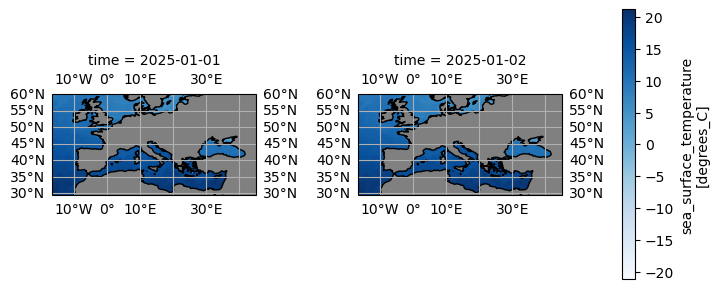

In [18]:
quick_data_plot(ds_custom['thetao'].isel(depth=0, time=[0, -1]))

### Using polygeohasher subpackage

The polygeohasher subpackage allows the user to manipulate country geometries and geohashes.
In the case of Copernicus, since this is all about marine/oceanographic data using country is less useful except if there is water area in the BBOX of the country.

#### With a country geometry

This exemple uses France because we can see some water area inside the bbox.

In [19]:
FRA_DF = download_gadm_country('FRA', cache_dir="../../gadm_cache")
FRA_GEOM = build_single_multipolygon(FRA_DF)

[20:51:17] INFO:sigmap.polygeohasher.utils.gadm_download: Found cached shapefile: ../../gadm_cache/gadm41_FRA_0.shp
[20:51:17] INFO:sigmap.polygeohasher.utils.gadm_download: Loading from cache: ../../gadm_cache/gadm41_FRA_0.shp


In [20]:
output_path= DS_FOLDER + "FRA_sst_exemple_PT1H-m.nc"
geometry: Union[Polygon, MultiPolygon, str, List[str], None] =FRA_GEOM

In [21]:
copernicus.fetch_copernicus_data(
        dataset_id=dataset_id,
        variables=['thetao'],
        output_path=output_path,
        geometry=geometry,
        time_range=time_range
    )
ds_country = xr.open_dataset(output_path)
ds_country

[20:51:18] INFO:sigmap.data.copernicus: File already exists (skipping download): ../../datasets/FRA_sst_exemple_PT1H-m.nc


<xarray.Dataset> Size: 2MB
Dimensions:    (time: 25, depth: 1, latitude: 117, longitude: 176)
Coordinates:
  * time       (time) datetime64[ns] 200B 2025-01-01 ... 2025-01-02
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 468B 41.42 41.5 41.58 ... 50.92 51.0 51.08
  * longitude  (longitude) float32 704B -5.083 -5.0 -4.917 ... 9.333 9.417 9.5
Data variables:
    thetao     (time, depth, latitude, longitude) float32 2MB ...
Attributes:
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    title:                     hourly mean fields from Global Ocean Physics A...
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    credit:                    E.U. Copernicus Marine Service Information (CM...
    contact:                   https://marine.copernicus.eu/contact
    institution:               Mercator Ocean International
    Conventions:               CF-1.8
    copernicusmarine_version:  2.2.3

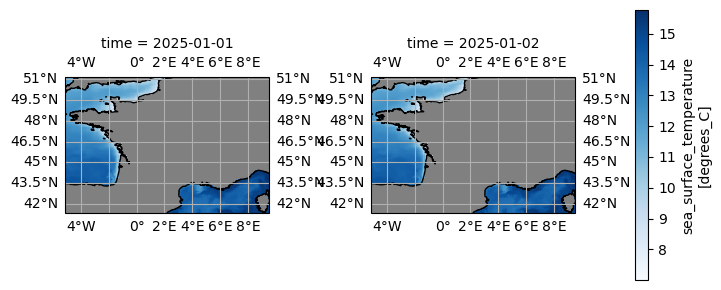

In [22]:
quick_data_plot(ds_country['thetao'].isel(depth=0, time=[0, -1]))

### Using Geohashes

Here we can use a geohash or a list of geohashes to determine our AOI.
The default behavior take all the geohashes, combine it into a MultiPolygon or Polygon to take the bbox of the resulting geometry.

In [23]:
output_path= DS_FOLDER + "GEOHASH_sst_exemple_PT1H-m.nc"
# Separate polygons
group1 = ["gg4", "gg5", "gff", "gfg"]
group2 = ["gf0", "gf1"]
group3 = ["gfy", "gfz","gfw","gfx"]

all_geohashes = group1 + group2 + group3

In [24]:
copernicus.fetch_copernicus_data(
        dataset_id=dataset_id,
        variables=['thetao'],
        output_path=output_path,
        geometry=all_geohashes,
        time_range=time_range,
    )

[20:51:19] INFO:sigmap.data.copernicus: File already exists (skipping download): ../../datasets/GEOHASH_sst_exemple_PT1H-m.nc


PosixPath('../../datasets/GEOHASH_sst_exemple_PT1H-m.nc')

In [25]:
ds_geohash = xr.open_dataset(output_path)
ds_geohash

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 25, depth: 1, latitude: 85, longitude: 136)
Coordinates:
  * time       (time) datetime64[ns] 200B 2025-01-01 ... 2025-01-02
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 340B 56.25 56.33 56.42 ... 63.08 63.17 63.25
  * longitude  (longitude) float32 544B -11.25 -11.17 -11.08 ... -0.08333 0.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 1MB ...
Attributes:
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    title:                     hourly mean fields from Global Ocean Physics A...
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    credit:                    E.U. Copernicus Marine Service Information (CM...
    contact:                   https://marine.copernicus.eu/contact
    institution:               Mercator Ocean International
    Conventions:               CF-1.8
    copernicusmarine_version:  2.2.3

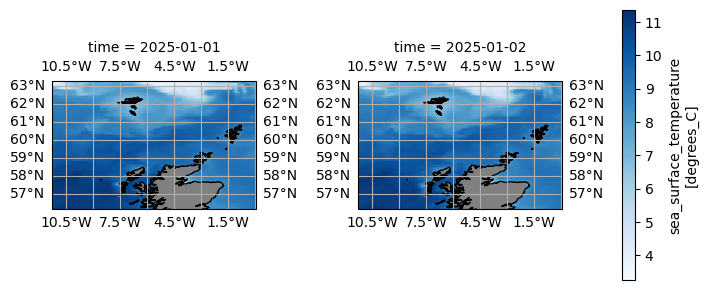

In [26]:
quick_data_plot(ds_geohash['thetao'].isel(depth=0, time=[0, -1]))

### Using geometries as a mask for the dataset

One of the main feature is to set the boolean parameter ```mask_using_geom=True```, this will take the dataset and the geometry you pass and apply the geometry as a mask.

It override the resulting dataset to only contains data inside the specified geometry.

The values outside will be set to ```NaN```.

In [27]:
output_path_mask= DS_FOLDER + "MASK_GEOHASH_sst_exemple_PT1H-m.nc"

group1 = ["gg4", "gg5", "gff", "gfg"]
group2 = ["gf0", "gf1"]
group3 = ["gfy", "gfz","gfw","gfx"]

all_geohashes = group1 + group2 + group3

In [28]:
copernicus.fetch_copernicus_data(
    dataset_id=dataset_id,
    variables=['thetao'],
    output_path=output_path_mask,
    geometry=all_geohashes,  # Can be geohashes, Polygon, or MultiPolygon
    time_range=time_range,
    force_download=True,
    mask_using_geom=True  # Enable masking
)

[20:51:19] INFO:sigmap.data.copernicus: Force download enabled — removing existing file: ../../datasets/MASK_GEOHASH_sst_exemple_PT1H-m.nc
[20:51:19] INFO:sigmap.data.copernicus: Fetching Copernicus data:
[20:51:19] INFO:sigmap.data.copernicus:   Dataset: cmems_mod_glo_phy_anfc_0.083deg_PT1H-m
[20:51:19] INFO:sigmap.data.copernicus:   Variables: ['thetao']
[20:51:19] INFO:sigmap.data.copernicus:   Bbox: (-11.25, 56.25, 0.0, 63.28125)
[20:51:19] INFO:sigmap.data.copernicus:   Mask using geometry: True
[20:51:19] INFO:sigmap.data.copernicus:   Output: ../../datasets/MASK_GEOHASH_sst_exemple_PT1H-m.nc
100%|██████████| 19/19 [00:07<00:00,  2.69it/s]
[20:51:28] INFO:sigmap.data.copernicus: Successfully downloaded to: ../../datasets/MASK_GEOHASH_sst_exemple_PT1H-m.nc
[20:51:28] INFO:sigmap.data.copernicus: Masking dataset with geometry: ../../datasets/MASK_GEOHASH_sst_exemple_PT1H-m.nc
[20:51:28] INFO:sigmap.data.copernicus: Using coordinates: lon='longitude', lat='latitude'
[20:51:28] INFO:

PosixPath('../../datasets/MASK_GEOHASH_sst_exemple_PT1H-m.nc')

In [29]:
ds_geohash_mask = xr.open_dataset(output_path_mask)
ds_geohash_mask

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 25, depth: 1, latitude: 85, longitude: 136)
Coordinates:
  * time       (time) datetime64[ns] 200B 2025-01-01 ... 2025-01-02
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 340B 56.25 56.33 56.42 ... 63.08 63.17 63.25
  * longitude  (longitude) float32 544B -11.25 -11.17 -11.08 ... -0.08333 0.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 1MB ...
Attributes:
    credit:                    E.U. Copernicus Marine Service Information (CM...
    Conventions:               CF-1.8
    institution:               Mercator Ocean International
    references:                http://marine.copernicus.eu
    source:                    MOI GLO12
    title:                     hourly mean fields from Global Ocean Physics A...
    contact:                   https://marine.copernicus.eu/contact
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    copernicusmarine_version:  2.2.3

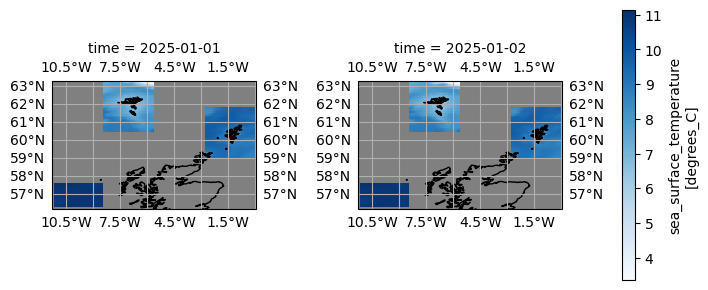

In [30]:
quick_data_plot(ds_geohash_mask['thetao'].isel(depth=0, time=[0, -1]))

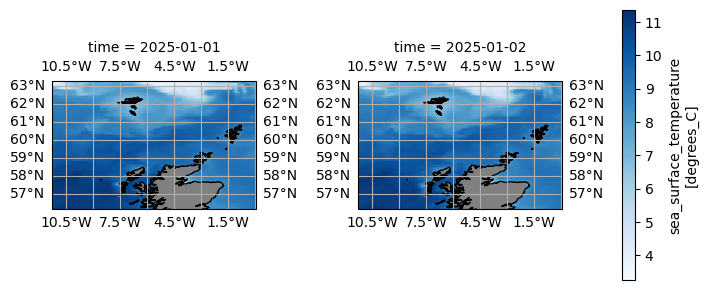

In [31]:
# Replot the same dataset without the mask to compare results.
quick_data_plot(ds_geohash['thetao'].isel(depth=0, time=[0, -1]))